In [ ]:
#TODO
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from yt_dlp import YoutubeDL
import re

# Define the graph state
class State(TypedDict):
    messages: Annotated[List, add_messages]
    valid_titles: List[str]
    invalid_titles: List[str]

graph_builder = StateGraph(State)

# Initialize LLM
llm = ChatOllama(model="gemma3:4b")

def get_song_suggestions(state: State) -> dict:
    prompt_template_path = "prompts/suggest_songs.txt"
    with open(prompt_template_path, "r", encoding="utf-8") as file:
        raw_prompt = file.read()

    prompt = PromptTemplate.from_template(raw_prompt)
    formatted_prompt = prompt.format(mood=state["messages"][-1].content)
    response = llm.invoke([HumanMessage(content=formatted_prompt)])
    return {"messages": [AIMessage(content=response.content)]}

def validate_titles(state: State) -> dict:
    suggestions = state["messages"][-1].content
    pattern = re.compile(r'\d+\.\s*(.+?)\s*-\s*(.+)')
    lines = suggestions.strip().splitlines()

    valid, invalid = [], []
    for line in lines:
        match = pattern.search(line)
        if not match:
            continue
        artist, title = match.groups()
        full_title = f"{artist.strip()} - {title.strip()}"
        if is_title_plausible(full_title):
            valid.append(full_title)
        else:
            invalid.append(full_title)
    return {"valid_titles": valid, "invalid_titles": invalid}

def is_title_plausible(song_title: str) -> bool:
    opts = {
        "quiet": True,
        "default_search": "ytsearch1",
        "noplaylist": True,
        "skip_download": True,
    }
    try:
        with YoutubeDL(opts) as ydl:
            info = ydl.extract_info(f"ytsearch:{song_title}", download=False)
            actual_title = info['entries'][0]['title'].lower()
            return all(word.lower() in actual_title for word in song_title.split()[:2])
    except Exception:
        return False

# Build the graph
graph_builder.add_node("suggest_songs", get_song_suggestions)
graph_builder.add_node("validate", validate_titles)
graph_builder.add_edge(START, "suggest_songs")
graph_builder.add_edge("suggest_songs", "validate")
graph_builder.add_edge("validate", END)
chatbot_graph = graph_builder.compile()

# Run the graph
def run_mood_to_song_graph(user_prompt):
    state = {
        "messages": [{"role": "user", "content": user_prompt}],
        "valid_titles": [],
        "invalid_titles": []
    }
    return chatbot_graph.invoke(state)

if __name__ == "__main__":
    user_input = "Feeling nostalgic. Can I get 10 emotional 80s metal songs?"
    result = run_mood_to_song_graph(user_input)
    print("✅ Valid Titles:", result["valid_titles"])
    print("❌ Hallucinated Titles:", result["invalid_titles"])


✅ Valid Titles: ['Iron Maiden - Run to the Hills', 'Def Leppard - Pour Some Love on Me', 'Dokken - Dream Anna', 'Scorpions - Rock You Like a Hurricane', 'Dio - Holy Roller', 'Raven - Candlelight Burning']
❌ Hallucinated Titles: ['Mötley Crue - Girls, Girls, Girls', 'Guns N’ Roses - Sweet Child o’ Mine', 'Winger - Sunday Morning', 'Saxon - Witch Hunter']


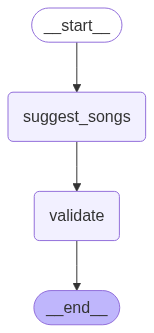

In [11]:
chatbot_graph
